In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LSTM, Activation, Flatten, Dropout, SimpleRNN, Bidirectional, Conv1D, GRU, BatchNormalization,Input
from keras.models import Model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
#import seaborn as sns
py.init_notebook_mode(connected=True)
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
import fix_yahoo_finance as yf
%matplotlib inline

Using TensorFlow backend.


In [2]:
Stock="AAPL"
param = {
    'q': Stock, # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    # Stock exchange symbol on which stock is traded (ex: "NASD")
     'p':'5Y'# Period (Ex: "1Y" = 1 year)
}
# get price data (return pandas dataframe)
#df = get_price_data(param)
  
df = yf.download(Stock,'2013-06-27')
df.to_csv(Stock+'.csv')
df.tail()

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-22,186.119995,186.149994,184.699997,184.919998,184.919998,27200400
2018-06-25,183.399994,184.919998,180.729996,182.169998,182.169998,31663100
2018-06-26,182.990005,186.529999,182.539993,184.429993,184.429993,24569200
2018-06-27,185.229996,187.279999,184.029999,184.160004,184.160004,25037500
2018-06-28,184.100006,186.210007,183.805801,185.500000,185.500000,15737005


In [3]:
data=df
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [5]:
data['Close'].replace(0, np.nan, inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [4]:
btc_trace = go.Scatter(x=data.index, y=data['Close'], name= 'Price')
py.iplot([btc_trace])

In [6]:
predictDates = data.tail(len(data)).index

In [12]:
predictDates

DatetimeIndex(['2003-06-24 13:00:00', '2003-06-25 13:00:00',
               '2003-06-26 13:00:00', '2003-06-27 13:00:00',
               '2003-06-30 13:00:00', '2003-07-01 13:00:00',
               '2003-07-02 13:00:00', '2003-07-03 13:00:00',
               '2003-07-07 13:00:00', '2003-07-08 13:00:00',
               ...
               '2018-06-08 13:00:00', '2018-06-11 13:00:00',
               '2018-06-12 13:00:00', '2018-06-13 13:00:00',
               '2018-06-14 13:00:00', '2018-06-15 13:00:00',
               '2018-06-18 13:00:00', '2018-06-19 13:00:00',
               '2018-06-20 13:00:00', '2018-06-21 13:00:00'],
              dtype='datetime64[ns]', length=3775, freq=None)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
#values = data[['Weighted'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = data[['High'] + ['Low'] + ['Volume'] + ['Adj Close'] + ['Open'] + ['Close']]
#values.insert(3,'Volume',data['Volume'])#.rolling(window=50).mean())
values.insert(4,'M150',data['Close'].rolling(window=50).mean())
values.insert(5,'MA150',data['Close'].rolling(window=150).mean())
values.insert(7,'dif',data['Open']-data['Close'])
#values.insert(6, 'EMA20', data['Close'].ewm(span=20, adjust=False).mean())
#values.insert(5,'open', data['Open'])
#values=values.iloc[:,1:]
values.dropna(inplace=True)
#values=values.values
values = values.astype('float32')

C:\Users\aalahgholipour160413\AppData\Local\Continuum\anaconda3\envs\keras 2.2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [9]:
values.head()

,High,Low,Volume,Adj Close,M150,MA150,Open,dif,Close
Date,,,,,,,,,
2014-01-30,72.357140,70.957146,169625408.0,61.190922,77.976746,71.563858,71.791428,0.394287,71.397141
2014-01-31,71.647141,70.507141,116199296.0,61.291309,77.925224,71.665588,70.739998,-0.774284,71.514282
2014-02-03,72.532860,71.328575,100366000.0,61.405186,77.873741,71.765587,71.801430,0.154289,71.647141
2014-02-04,72.779999,71.822861,94170304.0,62.294071,77.856003,71.860420,72.264282,-0.420006,72.684288
2014-02-05,73.611427,72.321426,82086200.0,62.759319,77.831573,71.950035,72.365715,-0.861427,73.227142


In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [10]:
scaled=values
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t)
Date,,,,,,,,,,,,,,,,,,
2014-01-31,72.357140,70.957146,169625408.0,61.190922,77.976746,71.563858,71.791428,0.394287,71.397141,71.647141,70.507141,116199296.0,61.291309,77.925224,71.665588,70.739998,-0.774284,71.514282
2014-02-03,71.647141,70.507141,116199296.0,61.291309,77.925224,71.665588,70.739998,-0.774284,71.514282,72.532860,71.328575,100366000.0,61.405186,77.873741,71.765587,71.801430,0.154289,71.647141
2014-02-04,72.532860,71.328575,100366000.0,61.405186,77.873741,71.765587,71.801430,0.154289,71.647141,72.779999,71.822861,94170304.0,62.294071,77.856003,71.860420,72.264282,-0.420006,72.684288
2014-02-05,72.779999,71.822861,94170304.0,62.294071,77.856003,71.860420,72.264282,-0.420006,72.684288,73.611427,72.321426,82086200.0,62.759319,77.831573,71.950035,72.365715,-0.861427,73.227142
2014-02-06,73.611427,72.321426,82086200.0,62.759319,77.831573,71.950035,72.365715,-0.861427,73.227142,73.357140,72.544289,64441300.0,65.476723,77.810745,72.037384,72.865715,-0.349999,73.215714


In [11]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

            var1(t-1)  var2(t-1)    var3(t-1)  var4(t-1)  var5(t-1)  \
Date                                                                  
2014-01-31  72.357140  70.957146  169625408.0  61.190922  77.976746   
2014-02-03  71.647141  70.507141  116199296.0  61.291309  77.925224   
2014-02-04  72.532860  71.328575  100366000.0  61.405186  77.873741   
2014-02-05  72.779999  71.822861   94170304.0  62.294071  77.856003   
2014-02-06  73.611427  72.321426   82086200.0  62.759319  77.831573   

            var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)   var8(t)    var9(t)  
Date                                                                         
2014-01-31  71.563858  71.791428   0.394287  71.397141 -0.774284  71.514282  
2014-02-03  71.665588  70.739998  -0.774284  71.514282  0.154289  71.647141  
2014-02-04  71.765587  71.801430   0.154289  71.647141 -0.420006  72.684288  
2014-02-05  71.860420  72.264282  -0.420006  72.684288 -0.861427  73.227142  
2014-02-06  71.950035  72.365715  

In [12]:
values = reframed.values
n_train_hours = int(len(values) * 0.85)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(944, 1, 9) (944, 2) (167, 1, 9) (167, 2)


In [42]:
from keras.callbacks import ReduceLROnPlateau
multi_model = Sequential()
multi_model.add(GRU(300, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
multi_model.add(GRU(200,dropout=0.2))
#multi_model.add(Dense(30,activation='relu'))
#multi_model.add(Dense(10,activation='relu'))
multi_model.add(Dense(2))
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
multi_model.compile(loss='mae', optimizer=ad)
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=False)

TypeError: The added layer must be an instance of class Layer. Found: Tensor("input_1:0", shape=(?, 1, 9), dtype=float32)

In [19]:
from keras.callbacks import ReduceLROnPlateau
inp = Input(shape=(train_X.shape[1], train_X.shape[2]))
out = BatchNormalization()(inp)
out = GRU(300, return_sequences=True)(out)
out = GRU(200,dropout=0.2)(out)
out = Dense(2)(out)
model = Model(inp,out)
ad = optimizers.Adam(lr=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)
model.compile(loss='mae', optimizer=ad)
multi_history = model.fit(train_X, train_y, epochs=300, batch_size=100, callbacks=[reduce_lr],  validation_data=(test_X, test_y), verbose=0, shuffle=False)


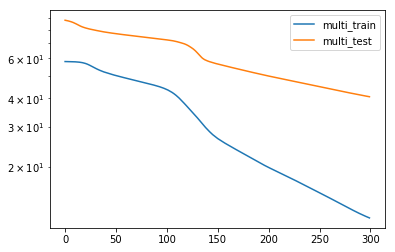

In [20]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.yscale('log')
pyplot.show()

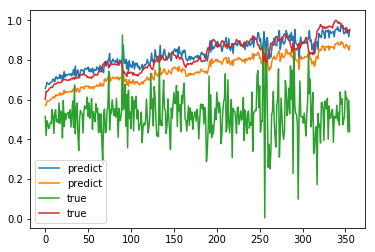

In [34]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()


In [23]:
diff1=np.concatenate((np.ediff1d(test_y[:-1,0]).reshape(len(test_y[:-1])-1,1),np.ediff1d(yhat[1:,0]).reshape(len(yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff1[:,0],diff1[:,1])
len(mul[mul>=0])/len(mul)

0.827683615819209

In [23]:
diff2=np.concatenate((np.ediff1d(test_y[:-1,1]).reshape(len(test_y[:-1])-1,1),np.ediff1d(yhat[1:,1]).reshape(len(yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff2[:,0],diff2[:,1])
len(mul[mul>=0])/len(mul)

0.8524096385542169

In [25]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, :-1],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1:]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1:]

In [28]:
diff=np.concatenate((np.ediff1d(inv_y[:-1]).reshape(len(inv_y[:-1])-1,1),np.ediff1d(inv_yhat[1:]).reshape(len(inv_yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff[:,0],diff[:,1])
len(mul[mul>=0])/len(mul)

0.8373493975903614

In [26]:
diff2=np.concatenate((np.ediff1d(inv_y[:-1,1]).reshape(len(inv_y[:-1])-1,1),np.ediff1d(inv_yhat[1:,1]).reshape(len(inv_yhat[1:])-1,1)),axis=1)
mul = np.multiply(diff2[:,0],diff2[:,1])
len(mul[mul>=0])/len(mul)

0.8524096385542169

In [27]:
rmse = sqrt(mean_squared_error(inv_y[:-1], inv_yhat[1:]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.867


In [28]:
mul = np.multiply((inv_yhat[:,0]-inv_yhat[:,1]),(inv_y[:,0]-inv_y[:,1]))
len(mul[mul>=0])/len(mul)

0.44610778443113774

In [25]:
df[-3:]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-26,182.990005,186.529999,182.539993,184.429993,184.429993,24569200
2018-06-27,185.229996,187.279999,184.029999,184.160004,184.160004,25037500
2018-06-28,184.100006,186.210007,183.805801,185.500000,185.500000,15737005


In [26]:
inv_yhat[-3:]

array([[ 186.40775055,  185.68081877],
       [ 187.72538552,  186.99448498],
       [ 188.38157351,  187.63188278]])